In [1]:
# Cella 1 (Revisionata): Setup del Progetto, Librerie e Riproducibilità

# ------------------------------------------
# Gestione File e Sistema Operativo
# ------------------------------------------
import os
import zipfile
import random

# ------------------------------------------
# Manipolazione Dati e Calcolo Numerico
# ------------------------------------------
import numpy as np
import pandas as pd

# ------------------------------------------
# Audio Processing
# ------------------------------------------
import librosa
import librosa.display

# ------------------------------------------
# Visualizzazione
# ------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------
# Machine Learning e Deep Learning
# ------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    PReLU,
    MaxPooling2D,
    Conv2DTranspose,
    Add,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# ------------------------------------------
# Impostazione per la Riproducibilità
# ------------------------------------------
# Impostare un seed garantisce che gli esperimenti siano riproducibili.
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Seed per la riproducibilità impostato a: {SEED}")


# ------------------------------------------
# Stile Grafici e Verifica GPU
# ------------------------------------------
plt.style.use('seaborn-v0_8-darkgrid')
print("\nTensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("GPU sarà usata per l'addestramento.")
else:
    print("ATTENZIONE: Nessuna GPU trovata. L'addestramento sarà estremamente lento.")

Seed per la riproducibilità impostato a: 42

TensorFlow Version: 2.18.0
Num GPUs Available:  1
GPU sarà usata per l'addestramento.


In [2]:
# Cella 2 (Invariata): Download e Estrazione del Dataset GTZAN

# ------------------------------------------
# Configurazione dell'API di Kaggle
# ------------------------------------------
# Installiamo la libreria di Kaggle in modalità "silenziosa" (-q)
!pip install -q kaggle
# Creiamo la directory necessaria per il file di configurazione
!mkdir -p ~/.kaggle

from google.colab import files
print("Per favore, carica il tuo file 'kaggle.json'...")
# L'upload si bloccherà se il file è già presente nella sessione corrente.
# Se hai problemi, puoi cancellare il file dal pannello a sinistra e riprovare.
try:
    files.upload()
except Exception as e:
    print(f"Potrebbe essere già presente un file 'kaggle.json'. Errore: {e}")


# Copiamo il file JSON e impostiamo i permessi corretti
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nConfigurazione Kaggle completata.")

# ------------------------------------------
# Download ed Estrazione del Dataset
# ------------------------------------------
DATASET_PATH = "dataset"
DATASET_ZIP_PATH = "gtzan-dataset-music-genre-classification.zip"

if not os.path.exists(DATASET_PATH):
    print("\nDownload del dataset GTZAN in corso...")
    !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

    print("\nEstrazione del dataset in corso...")
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)
    # Rimuoviamo il file .zip per liberare spazio
    os.remove(DATASET_ZIP_PATH)
    print("Download ed Estrazione completati.")
else:
    print(f"\nLa directory '{DATASET_PATH}' esiste già. Salto il download e l'estrazione.")

# ------------------------------------------
# Verifica del contenuto e pulizia
# ------------------------------------------
GENRES_PATH = os.path.join(DATASET_PATH, 'Data', 'genres_original')

# Rimuoviamo un file noto per essere corrotto nel dataset GTZAN
corrupted_file_path = os.path.join(GENRES_PATH, 'jazz', 'jazz.00054.wav')
if os.path.exists(corrupted_file_path):
    os.remove(corrupted_file_path)
    print(f"Rimosso file corrotto: {corrupted_file_path}")

print(f"\nGeneri musicali trovati in '{GENRES_PATH}':")
# Controlliamo che le directory dei generi esistano e le elenchiamo
if os.path.exists(GENRES_PATH):
    genres = sorted([d for d in os.listdir(GENRES_PATH) if os.path.isdir(os.path.join(GENRES_PATH, d))])
    print(genres)
else:
    print(f"ERRORE: La directory dei generi '{GENRES_PATH}' non è stata trovata. Controlla il processo di estrazione.")

Per favore, carica il tuo file 'kaggle.json'...


Saving kaggle.json to kaggle.json

Configurazione Kaggle completata.

Download del dataset GTZAN in corso...
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 97% 1.18G/1.21G [00:08<00:00, 140MB/s]
100% 1.21G/1.21G [00:08<00:00, 161MB/s]

Estrazione del dataset in corso...
Download ed Estrazione completati.
Rimosso file corrotto: dataset/Data/genres_original/jazz/jazz.00054.wav

Generi musicali trovati in 'dataset/Data/genres_original':
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [3]:
# Cella 3 (Revisionata): Preprocessing con Chunking (Frammentazione)

# ------------------------------------------
# Costanti di Preprocessing
# ------------------------------------------
# Definiamo il percorso per il file .npz che conterrà gli spettrogrammi processati.
# Questo ci permette di eseguire il preprocessing una sola volta.
NPZ_PATH_CHUNKS = "spectrograms_128_chunks.npz"

# Parametri per la generazione degli spettrogrammi
IMG_SIZE = 128      # Dimensione finale delle immagini (128x128 pixel)
SAMPLE_RATE = 22050   # Frequenza di campionamento standard per l'audio
DURATION_FULL = 30    # Durata totale di ogni file audio in secondi
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION_FULL

# Parametri per il Chunking (Data Augmentation)
# Dividiamo ogni brano di 30s in 10 chunk da 3s per aumentare i dati di 10 volte.
NUM_CHUNKS = 10
SAMPLES_PER_CHUNK = int(SAMPLES_PER_TRACK / NUM_CHUNKS)

# Parametri per la trasformata di Fourier (STFT) e i Mel-Spettrogrammi
N_MELS = 128     # Numero di bande di Mel (altezza dell'immagine)
HOP_LENGTH = 512 # Salto tra finestre successive della STFT
N_FFT = 2048     # Dimensione della finestra della STFT

# ------------------------------------------
# Funzione di Preprocessing con Chunking
# ------------------------------------------
def create_chunked_spectrograms(data_path, npz_path):
    """
    Carica i file audio, li divide in chunk, calcola i mel-spettrogrammi,
    li converte in immagini e li salva in un file .npz compresso.
    """
    # Se i dati sono già stati processati, salta questa lunga operazione.
    if os.path.exists(npz_path):
        print(f"File '{npz_path}' trovato. Salto il preprocessing.")
        return

    # Dizionario per accumulare immagini e etichette
    data = {"images": [], "labels": []}
    all_genres = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

    print(f"Inizio preprocessing con chunking ({NUM_CHUNKS} chunk per brano)...")
    # Itera su ogni genere (es. 'blues', 'classical', ...)
    for genre_idx, genre_label in enumerate(tqdm(all_genres, desc="Generi")):
        genre_path = os.path.join(data_path, genre_label)

        # Itera su ogni file .wav nella directory del genere
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                try:
                    # Carica il segnale audio con librosa
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # Suddivide il segnale in chunk e processa ciascuno
                    for c in range(NUM_CHUNKS):
                        start_sample = SAMPLES_PER_CHUNK * c
                        end_sample = start_sample + SAMPLES_PER_CHUNK

                        # Assicuriamoci che il chunk sia della lunghezza corretta
                        if end_sample <= len(signal):
                            chunk_signal = signal[start_sample:end_sample]

                            # 1. Calcola il mel-spettrogramma
                            mel_spec = librosa.feature.melspectrogram(
                                y=chunk_signal, sr=sr, n_fft=N_FFT,
                                hop_length=HOP_LENGTH, n_mels=N_MELS
                            )
                            # 2. Converte in scala logaritmica (dB), più vicina alla percezione umana
                            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                            # 3. Normalizza i valori tra 0 e 1 per creare un'immagine
                            img = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())

                            # 4. Ridimensiona a IMG_SIZE x IMG_SIZE e converte in RGB
                            # Aggiungiamo una dimensione per il canale (grayscale)
                            img_gray = img[..., np.newaxis]
                            # Ridimensioniamo l'immagine
                            resized_spec = tf.image.resize(img_gray, [IMG_SIZE, IMG_SIZE])
                            # Convertiamo in RGB (3 canali) per compatibilità con architetture CNN comuni
                            img_rgb = tf.image.grayscale_to_rgb(resized_spec)

                            # Aggiungiamo l'immagine (come uint8 per risparmiare memoria) e l'etichetta
                            data["images"].append((img_rgb.numpy() * 255).astype(np.uint8))
                            data["labels"].append(genre_idx)
                except Exception as e:
                    print(f"\nErrore durante l'elaborazione di {file_path}: {e}")

    # Salviamo tutto in un unico file .npz compresso per un caricamento veloce
    np.savez_compressed(
        npz_path,
        X=np.array(data["images"]),
        y=np.array(data["labels"]),
        mappings=all_genres
    )
    print(f"\nDati salvati in '{npz_path}'. Shape totale di X: {np.array(data['images']).shape}")

# Eseguiamo la funzione di preprocessing
create_chunked_spectrograms(GENRES_PATH, NPZ_PATH_CHUNKS)

Inizio preprocessing con chunking (10 chunk per brano)...


Generi: 100%|██████████| 10/10 [02:09<00:00, 12.93s/it]



Dati salvati in 'spectrograms_128_chunks.npz'. Shape totale di X: (9981, 128, 128, 3)


In [4]:
# Cella 4 (Revisionata): Preparazione Dati e Costruzione del Modello

import gc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, PReLU, MaxPooling2D, Conv2DTranspose,
    Add, GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# ------------------------------------------
# 1. Caricamento dei Dati Preprocessati
# ------------------------------------------
print(f"Caricamento dati chunked da '{NPZ_PATH_CHUNKS}'...")
with np.load(NPZ_PATH_CHUNKS, allow_pickle=True) as data:
    X_full = data['X']
    y_full = data['y']
    mappings = data['mappings']

print(f"Dati caricati. Shape di X: {X_full.shape}, Shape di y: {y_full.shape}")

# ------------------------------------------
# 2. Preparazione dei Dati per il Modello
# ------------------------------------------
# Normalizza i pixel delle immagini da [0, 255] a [0.0, 1.0]
X_normalized = X_full.astype('float32') / 255.0

# Converte le etichette in formato one-hot encoding (es. 3 -> [0,0,0,1,0...])
y_one_hot = to_categorical(y_full)

# Suddivide i dati in set di addestramento e test (80/20)
# Usiamo il SEED per uno split riproducibile e 'stratify' per mantenere le proporzioni delle classi.
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_one_hot, test_size=0.2, random_state=SEED, stratify=y_one_hot
)

print("\nDati suddivisi e pronti per l'addestramento.")
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")

# Liberiamo memoria cancellando le variabili non più necessarie
del X_full, y_full, X_normalized, y_one_hot
gc.collect()

# ------------------------------------------
# 3. Costruzione del Modello (Replicando la Fig. 1 del paper, adattata a 128x128)
# ------------------------------------------
def build_paper_model(input_shape, num_classes):
    """
    Costruisce un'architettura U-Net-like basata sulla Figura 1 del paper,
    adattata per immagini di input 128x128.
    """
    inputs = Input(shape=input_shape)

    # --- ENCODER (COMPRESS PATH) ---
    # Livello 1: 128 -> 64
    conv1 = Conv2D(16, (3, 3), padding='same')(inputs)
    prelu1 = PReLU(shared_axes=[1, 2])(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(prelu1)

    # Livello 2: 64 -> 32
    conv2 = Conv2D(32, (3, 3), padding='same')(pool1)
    prelu2 = PReLU(shared_axes=[1, 2])(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(prelu2)

    # Livello 3: 32 -> 16
    conv3 = Conv2D(64, (3, 3), padding='same')(pool2)
    prelu3 = PReLU(shared_axes=[1, 2])(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(prelu3)

    # --- BOTTLENECK ---
    conv_neck = Conv2D(128, (3, 3), padding='same')(pool3)
    prelu_neck = PReLU(shared_axes=[1, 2])(conv_neck)

    # --- DECODER (DECOMPRESS PATH) ---
    # Livello 3: 16 -> 32
    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(prelu_neck)
    skip3 = Add()([up3, prelu3]) # Skip connection
    conv3_dec = Conv2D(64, (3, 3), padding='same')(skip3)
    prelu3_dec = PReLU(shared_axes=[1, 2])(conv3_dec)

    # Livello 2: 32 -> 64
    up2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(prelu3_dec)
    skip2 = Add()([up2, prelu2]) # Skip connection
    conv2_dec = Conv2D(32, (3, 3), padding='same')(skip2)
    prelu2_dec = PReLU(shared_axes=[1, 2])(conv2_dec)

    # Livello 1: 64 -> 128
    up1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(prelu2_dec)
    skip1 = Add()([up1, prelu1]) # Skip connection
    conv1_dec = Conv2D(16, (3, 3), padding='same')(skip1)
    unet_output = PReLU(shared_axes=[1, 2])(conv1_dec)

    # --- TESTA DI CLASSIFICAZIONE ---
    # Aggiungiamo un blocco finale per la classificazione
    gap = GlobalAveragePooling2D()(unet_output)
    dropout = Dropout(0.5)(gap) # Dropout per regolarizzazione
    outputs = Dense(num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Definiamo le costanti per il modello
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
NUM_CLASSES = len(mappings)

# Costruiamo il modello
model = build_paper_model(INPUT_SHAPE, NUM_CLASSES)

# Compiliamo il modello usando l'ottimizzatore Adam, come richiesto dal paper
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Visualizziamo il riassunto dell'architettura
model.summary()

Caricamento dati chunked da 'spectrograms_128_chunks.npz'...
Dati caricati. Shape di X: (9981, 128, 128, 3), Shape di y: (9981,)

Dati suddivisi e pronti per l'addestramento.
Shape X_train: (7984, 128, 128, 3)
Shape X_test: (1997, 128, 128, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 128, 128,  │         16 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ p_re_lu[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 64, 64,    │         32 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ p_re_lu_1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ p_re_lu_2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 16, 16,    │        128 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ p_re_lu_3[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│                     │ 64)               │            │ p_re_lu_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 32, 32,    │         64 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │      8,224 │ p_re_lu_4[0][0] 

 Total params: 189,578 (740.54 KB)

 Trainable params: 189,578 (740.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Cella 5 (Revisionata): Addestramento del Modello

# ------------------------------------------
# Definizione dei Parametri di Addestramento
# ------------------------------------------
EPOCHS = 50
BATCH_SIZE = 32
MODEL_CHECKPOINT_PATH = "best_paper_model.keras" # Nome file aggiornato

# ------------------------------------------
# Definizione dei Callbacks
# ------------------------------------------

# 1. ModelCheckpoint: Salva il modello solo quando la 'val_accuracy' migliora.
#    In questo modo, alla fine avremo il modello con le migliori performance sul set di validazione.
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CHECKPOINT_PATH,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max' # 'max' perché vogliamo massimizzare l'accuracy
)

# 2. EarlyStopping: Ferma l'addestramento se la 'val_accuracy' non migliora
#    per un certo numero di epoche ('patience'), per evitare overfitting.
#    'restore_best_weights=True' assicura che il modello finale abbia i pesi della migliore epoca.
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10, # Numero di epoche senza miglioramenti prima di fermarsi
    verbose=1,
    restore_best_weights=True
)

# 3. ReduceLROnPlateau: Riduce dinamicamente il learning rate se la 'val_loss'
#    entra in un plateau, aiutando il modello a convergere meglio.
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,   # Fattore di riduzione (nuovo_lr = lr * factor)
    patience=4,   # Numero di epoche senza miglioramenti della loss prima di ridurre il lr
    verbose=1,
    min_lr=1e-6   # Learning rate minimo
)

# ------------------------------------------
# Avvio dell'Addestramento
# ------------------------------------------
print("--- Avvio Addestramento del Modello basato sul Paper ---")

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)

print("\n--- Addestramento Completato ---")

# ------------------------------------------
# Salva la cronologia per l'analisi futura
# ------------------------------------------
# Convertiamo l'oggetto history in un DataFrame di pandas per una facile manipolazione.
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_paper_model.csv', index=False)
print("\nCronologia dell'addestramento salvata in 'training_history_paper_model.csv'")

--- Avvio Addestramento del Modello basato sul Paper ---
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1122 - loss: 2.2858
Epoch 1: val_accuracy improved from -inf to 0.17276, saving model to best_paper_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.1123 - loss: 2.2857 - val_accuracy: 0.1728 - val_loss: 2.1909 - learning_rate: 0.0010
Epoch 2/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1937 - loss: 2.1386
Epoch 2: val_accuracy improved from 0.17276 to 0.32899, saving model to best_paper_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.1939 - loss: 2.1382 - val_accuracy: 0.3290 - val_loss: 1.9011 - learning_rate: 0.0010
Epoch 3/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2774 - loss: 1.9365
Epoch 3: val_accuracy improved from 0.32899 to 0.42614, saving model to best_paper_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.2776 - loss: 1.9361 - val_accuracy: 0.4261 - val_loss: 1.

Caricamento del miglior modello da 'best_paper_model.keras'...
Modello caricato con successo.


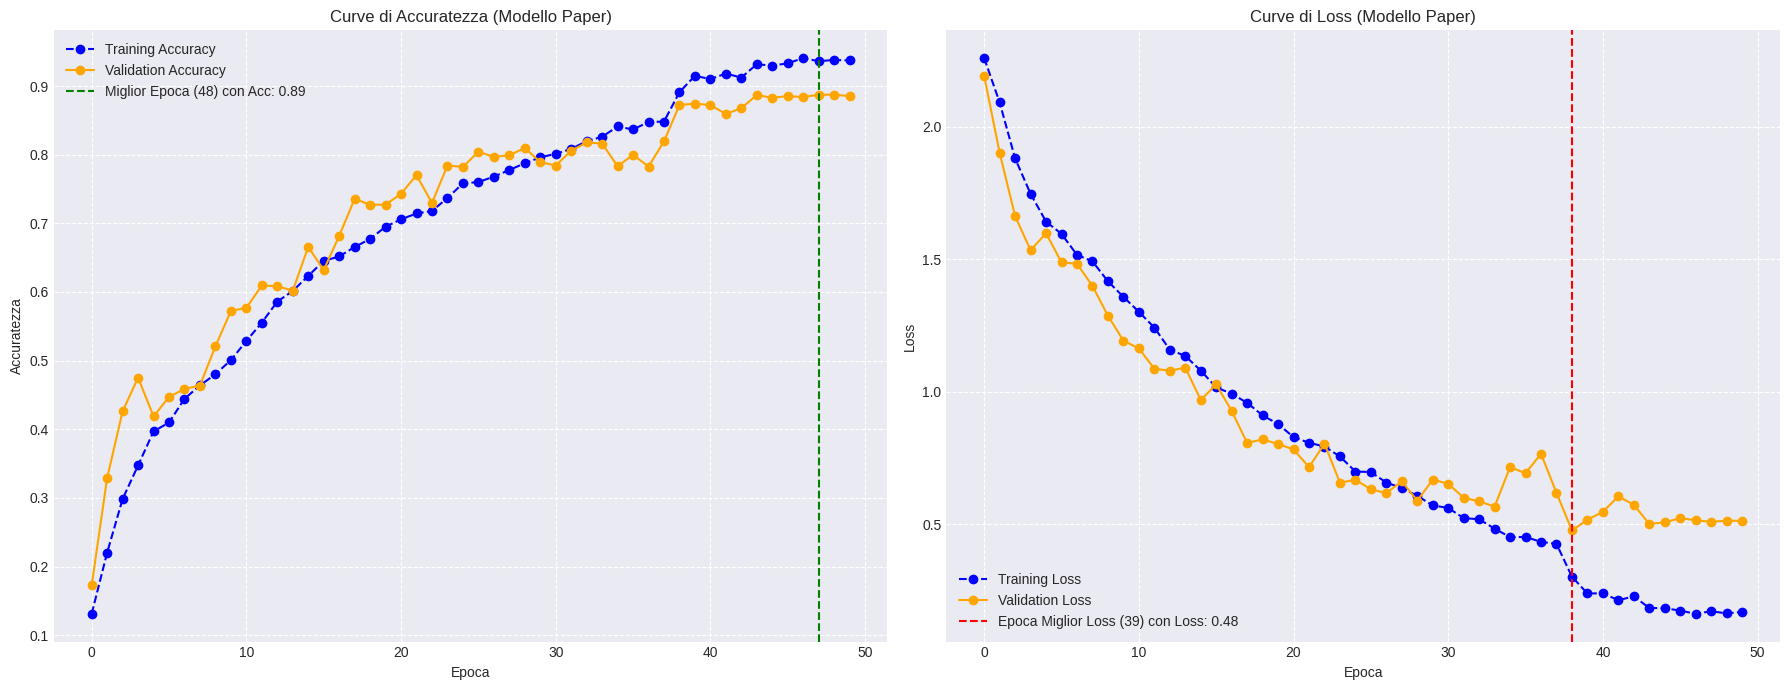


--- Valutazione Finale sul Test Set (Miglior Modello) ---
  Accuratezza sul Test Set: 88.73%
  Loss sul Test Set: 0.5084

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

--- Matrice di Confusione ---


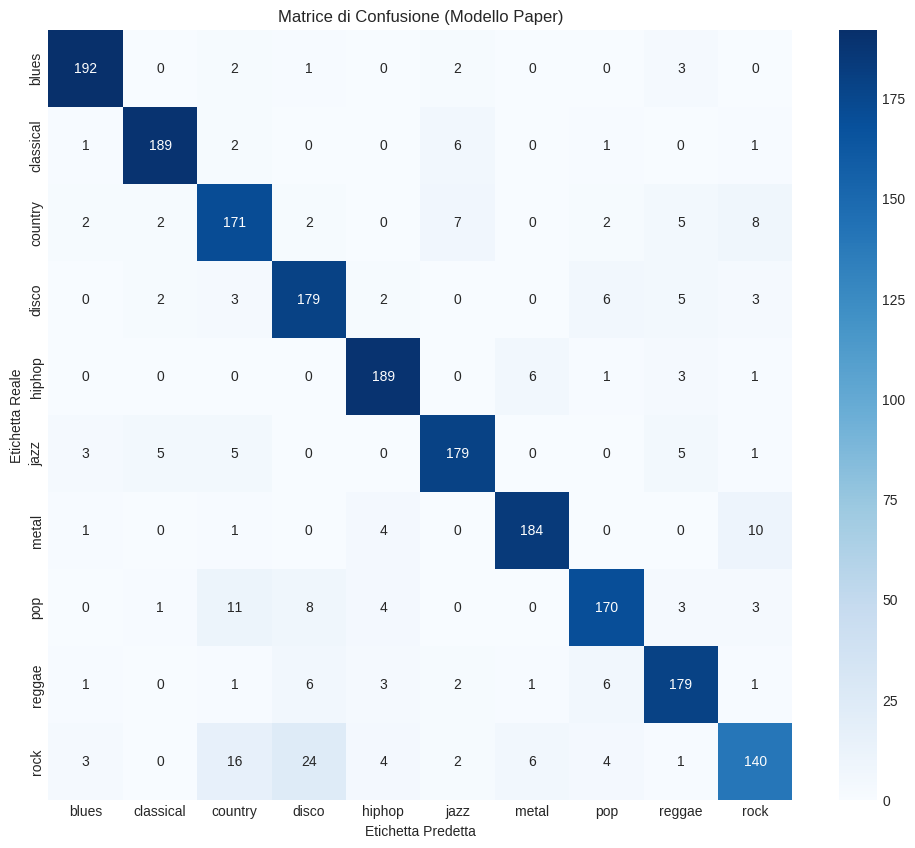


--- Classification Report ---
Qui sotto sono riportate le metriche di precision, recall e f1-score per ogni genere.
              precision    recall  f1-score   support

       blues      0.946     0.960     0.953       200
   classical      0.950     0.945     0.947       200
     country      0.807     0.859     0.832       199
       disco      0.814     0.895     0.852       200
      hiphop      0.917     0.945     0.931       200
        jazz      0.904     0.904     0.904       198
       metal      0.934     0.920     0.927       200
         pop      0.895     0.850     0.872       200
      reggae      0.877     0.895     0.886       200
        rock      0.833     0.700     0.761       200

    accuracy                          0.887      1997
   macro avg      0.888     0.887     0.887      1997
weighted avg      0.888     0.887     0.887      1997



In [7]:
# Cella 6 (Finale): Analisi dei Risultati e Valutazione del Modello

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

# ------------------------------------------
# 1. Caricamento del Miglior Modello Salvato
# ------------------------------------------
MODEL_CHECKPOINT_PATH = "best_paper_model.keras"
HISTORY_CSV_PATH = 'training_history_paper_model.csv'

print(f"Caricamento del miglior modello da '{MODEL_CHECKPOINT_PATH}'...")
try:
    best_model = keras.models.load_model(MODEL_CHECKPOINT_PATH)
    print("Modello caricato con successo.")
except Exception as e:
    print(f"Errore nel caricamento del modello: {e}")
    # Se c'è un errore, esce per non continuare con un modello non valido.
    exit()

# ------------------------------------------
# 2. Visualizzazione delle Curve di Apprendimento
# ------------------------------------------
try:
    history_df = pd.read_csv(HISTORY_CSV_PATH)

    plt.figure(figsize=(18, 7))

    # Grafico dell'Accuratezza
    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Training Accuracy', color='blue', marker='o', linestyle='--')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
    best_epoch = history_df['val_accuracy'].idxmax()
    plt.axvline(best_epoch, color='g', linestyle='--', label=f'Miglior Epoca ({best_epoch + 1}) con Acc: {history_df["val_accuracy"].max():.2f}')
    plt.title('Curve di Accuratezza (Modello Paper)')
    plt.xlabel('Epoca')
    plt.ylabel('Accuratezza')
    plt.legend()
    plt.grid(True, which='both', linestyle='--')

    # Grafico della Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Training Loss', color='blue', marker='o', linestyle='--')
    plt.plot(history_df['val_loss'], label='Validation Loss', color='orange', marker='o')
    best_loss_epoch = history_df['val_loss'].idxmin()
    plt.axvline(best_loss_epoch, color='r', linestyle='--', label=f'Epoca Miglior Loss ({best_loss_epoch + 1}) con Loss: {history_df["val_loss"].min():.2f}')
    plt.title('Curve di Loss (Modello Paper)')
    plt.xlabel('Epoca')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"File della cronologia '{HISTORY_CSV_PATH}' non trovato. Salto la visualizzazione delle curve.")


# ------------------------------------------
# 3. Valutazione Finale sul Test Set
# ------------------------------------------
print("\n" + "="*40)
print("--- Valutazione Finale sul Test Set (Miglior Modello) ---")
print("="*40)
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"  Accuratezza sul Test Set: {accuracy * 100:.2f}%")
print(f"  Loss sul Test Set: {loss:.4f}\n")


# ------------------------------------------
# 4. Matrice di Confusione e Classification Report
# ------------------------------------------
# Otteniamo le predizioni dal modello sul set di test
y_pred_probs = best_model.predict(X_test)
# Convertiamo le probabilità in etichette (l'indice con il valore più alto)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
# Convertiamo le etichette one-hot reali in etichette numeriche
y_true_labels = np.argmax(y_test, axis=1)

# Matrice di Confusione
print("\n" + "="*40)
print("--- Matrice di Confusione ---")
print("="*40)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=mappings, yticklabels=mappings)
plt.title('Matrice di Confusione (Modello Paper)')
plt.xlabel('Etichetta Predetta')
plt.ylabel('Etichetta Reale')
plt.show()

# Classification Report (Precision, Recall, F1-score)
print("\n" + "="*40)
print("--- Classification Report ---")
print("="*40)
print("Qui sotto sono riportate le metriche di precision, recall e f1-score per ogni genere.")
print(classification_report(y_true_labels, y_pred_labels, target_names=mappings, digits=3))